In [1]:
# cd("C:\\Users\\matsuno\\Desktop\\data_analysis\\HMMBase.jl\\src")
# include(".//HMMBase.jl")
# using .HMMBase

import Pkg
Pkg.activate("C://Users//matsuno//.julia//environments//v1.4.2//Project.toml")
Pkg.develop(Pkg.PackageSpec(url="C:\\Users\\matsuno\\Desktop\\data_analysis\\HMMBase.jl\\"))
using HMMBase

using Distributions
using Random
using PyPlot
using ArgCheck
import Base:OneTo

 Activating environment at `C:\Users\matsuno\.julia\environments\v1.4.2\Project.toml`
Path `C:\Users\matsuno\Desktop\data_analysis\HMMBase.jl\` exists and looks like the correct package. Using existing path.
  Resolving package versions...
   Updating `C:\Users\matsuno\.julia\environments\v1.4.2\Project.toml`
 [no changes]
   Updating `C:\Users\matsuno\.julia\environments\v1.4.2\Manifest.toml`
 [no changes]


# old test

In [2]:
using Test
using HMMBase
using Distributions
using Random

┌ Info: Precompiling HMMBase [b2b3ca75-8444-5ffa-85e6-af70e2b64fe7]
└ @ Base loading.jl:1260


In [9]:
hmm = HMM([0.9 0.1; 0.1 0.9], [Normal(10, 1), Gamma(1, 1)])
T = 0
z, y = rand(hmm, T, seq = true)
println("size(y) = $(size(y))")
println("size(z) = $(size(z))")
println("size(hmm) = $(size(hmm))")

size(y) = (0, 1)
size(z) = (0,)
size(hmm) = (2, 1)


In [6]:
Random.seed!(2019)

hmms = [
    HMM([0.9 0.1; 0.1 0.9], [Normal(10, 1), Gamma(1, 1)]),
    HMM([0.9 0.1; 0.1 0.9], [Categorical([0.1, 0.2, 0.7]), Categorical([0.5, 0.5])]),
    HMM([0.9 0.1; 0.1 0.9], [MvNormal([0.0, 0.0], [1.0, 1.0]), MvNormal([10.0, 10.0], [1.0, 1.0])]),
]

@testset "Integration $(typeof(hmm))" for hmm in hmms, T in [1, 1000]
    K = size(hmm, 1)

    # HMM API
    @test hmm !== copy(hmm)

    z, y = rand(hmm, T, seq = true)
    @test size(z, 1) == size(y, 1)
    @test size(y, 2) == size(hmm, 2)

    y = rand(hmm, z)
    @test size(z, 1) == size(y, 1)
    @test size(y, 2) == size(hmm, 2)

    LL = HMMBase.log_likelihoods(hmm, y)
    @test size(LL) == (T, K)

    # Forward/Backward
    α1, logtot1 = forward(hmm, y)
    β1, logtot2 = backward(hmm, y)
    γ1 = posteriors(hmm, y)
    logtot3 = loglikelihood(hmm, y)

    @test size(α1) == size(β1) == size(γ1)
    @test logtot1 ≈ logtot2 ≈ logtot3

    # Viterbi
#     zv1 = viterbi(hmm, y)
#     @test size(zv1) == size(z)

    # MLE
#     if T > 2
#         hmm2, _ = fit_mle(hmm, y, maxiter = 1, display = :iter)
#         @test size(hmm2) == size(hmm)
#         @test typeof(hmm2) == typeof(hmm)

#         hmm2, _ = fit_mle(hmm, y, init = nothing)
#         @test size(hmm2) == size(hmm)
#         @test typeof(hmm2) == typeof(hmm)

#         hmm2, _ = fit_mle(hmm, y, init = :kmeans, robust = true)
#         @test size(hmm2) == size(hmm)
#         @test typeof(hmm2) == typeof(hmm)
#     end
end

┌ Warning: `log_likelihoods(hmm, observations)` is deprecated, use `likelihoods(hmm, observations, logl = true)` instead.
│   caller = macro expansion at In[6]:28 [inlined]
└ @ Core .\In[6]:28


Test Summary:                       | Pass  Total
Integration HMM{Univariate,Float64} |    8      8
Iteration 0: logtot = -1502.640369942967
Iteration 1: logtot = -1499.8024144856909
EM has not converged after 1 iterations, logtot = -1499.8024144856909
Test Summary:                       | Pass  Total
Integration HMM{Univariate,Float64} |   14     14
Test Summary:                       | Pass  Total
Integration HMM{Univariate,Float64} |    8      8
Iteration 0: logtot = -943.6458420729922
Iteration 1: logtot = -941.7576975409776
EM has not converged after 1 iterations, logtot = -941.7576975409776
Test Summary:                       | Pass  Total
Integration HMM{Univariate,Float64} |   14     14
Test Summary:                         | Pass  Total
Integration HMM{Multivariate,Float64} |    8      8
Iteration 0: logtot = -3098.6892577753483
Iteration 1: logtot = -3092.6119242701548
EM has not converged after 1 iterations, logtot = -3092.6119242701548
Test Summary:                         

6-element Array{Any,1}:
 Test.DefaultTestSet("Integration HMM{Univariate,Float64}", Any[], 8, false)
 Test.DefaultTestSet("Integration HMM{Univariate,Float64}", Any[], 14, false)
 Test.DefaultTestSet("Integration HMM{Univariate,Float64}", Any[], 8, false)
 Test.DefaultTestSet("Integration HMM{Univariate,Float64}", Any[], 14, false)
 Test.DefaultTestSet("Integration HMM{Multivariate,Float64}", Any[], 8, false)
 Test.DefaultTestSet("Integration HMM{Multivariate,Float64}", Any[], 14, false)

In [13]:
using ArgCheck

In [26]:
Random.seed!(1234)
T = 100
N = 100
maxiter = 100
estimator = fit_mle
tol = 1e-3
robust = false

hmm = HMM([0.8 0.2; 0.2 0.8], [Normal(10, 1), Gamma(1, 1)])
z, y = rand(hmm, T, seq = true)
observations = copy(y)

T, K = size(observations, 1), size(hmm, 1)
history = HMMBase.EMHistory(false, 0, [])

# Allocate memory for in-place updates
c = zeros(T)
α = zeros(T, K)
β = zeros(T, K)
γ = zeros(T, K)
ξ = zeros(T, K, K)
LL = zeros(T, K)

HMMBase.loglikelihoods!(LL, hmm, observations)
robust && replace!(LL, -Inf => nextfloat(-Inf), Inf => log(prevfloat(Inf)))

HMMBase.forwardlog!(α, c, hmm.a, hmm.A, LL)
HMMBase.backwardlog!(β, c, hmm.a, hmm.A, LL)
HMMBase.posteriors!(γ, α, β)

logtot = sum(c)
(display == :iter) && println("Iteration 0: logtot = $logtot")

for it = 1:maxiter
    HMMBase.update_a!(hmm.a, α, β)
    HMMBase.update_A!(hmm.A, ξ, α, β, LL)
    HMMBase.update_B!(hmm.B, γ, observations, estimator)

    # Ensure the "connected-ness" of the states,
    # this prevents case where there is no transitions
    # between two extremely likely observations.
    robust && (hmm.A .+= eps())

    ArgCheck.@check isprobvec(hmm.a)
    ArgCheck.@check istransmat(hmm.A)

    HMMBase.loglikelihoods!(LL, hmm, observations)
    robust && replace!(LL, -Inf => nextfloat(-Inf), Inf => log(prevfloat(Inf)))

    HMMBase.forwardlog!(α, c, hmm.a, hmm.A, LL)
    HMMBase.backwardlog!(β, c, hmm.a, hmm.A, LL)
    HMMBase.posteriors!(γ, α, β)

    logtotp = sum(c)
    (display == :iter) && println("Iteration $it: logtot = $logtotp")

    push!(history.logtots, logtotp)
    history.iterations += 1

    if abs(logtotp - logtot) < tol
        (display in [:iter, :final]) &&
            println("EM converged in $it iterations, logtot = $logtotp")
        history.converged = true
        break
    end

    logtot = logtotp
end

if !history.converged
    if display in [:iter, :final]
        println("EM has not converged after $(history.iterations) iterations, logtot = $logtot")
    end
end

# new test

In [3]:
using Test
# using HMMBase
using Distributions
using Random

In [66]:
hmm = HMM([0.8 0.2; 0.2 0.8], [Categorical([0.1, 0.2, 0.7]), Categorical([0.5, 0.5])])
T = 0
z, y = rand(hmm, T, seq = true)
println("size(y) = $(size(y))")
println("size(z) = $(size(z))")
println("size(hmm) = $(size(hmm))")

size(y) = (0, 1)
size(z) = (0,)
size(hmm) = (2, 1)


In [70]:
Random.seed!(2019)

hmms = [
    HMM([0.8 0.2; 0.2 0.8], [Normal(10, 1), Gamma(1, 1)]),
    HMM([0.8 0.2; 0.2 0.8], [Categorical([0.1, 0.2, 0.7]), Categorical([0.5, 0.5])]),
    HMM([0.8 0.2; 0.2 0.8], [MvNormal([0.0, 0.0], [1.0, 1.0]), MvNormal([10.0, 10.0], [1.0, 1.0])]),
]

@testset "Integration $(typeof(hmm))" for hmm in hmms, T in [0, 1, 100], N in [0, 1, 100]
    K = size(hmm, 1)

    # HMM API
    @test hmm !== copy(hmm)

    z, y = rand(hmm, T, N, seq = true)
    @test size(z, 1) == size(y, 1)
    @test size(z, 2) == last(size(y))
    ((ndims(y) > 2) && (N >= 1)) && (@test size(y, 2) == size(hmm, 2))

    y = rand(hmm, z)
    @test size(z, 1) == size(y, 1)
    ((ndims(y) > 2) && (N >= 1)) && (@test size(y, 2) == size(hmm, 2))

    LL = loglikelihoods(hmm, y)
    @test size(LL) == (T, K, N)

    # Forward/Backward
    α1, logtot1 = forward(hmm, y)
    β1, logtot2 = backward(hmm, y)
    γ1 = posteriors(hmm, y)
    logtot3 = loglikelihood(hmm, y)

    @test size(α1) == size(β1) == size(γ1)
    @test logtot1 ≈ logtot2 ≈ logtot3
    
    # Viterbi
    zv1, _ = viterbi(hmm, y)
    @test size(zv1) == size(z)

    # MLE
    if T > 2
        hmm2, _ = fit_mle(hmm, y, maxiter = 1, display = :iter)
        @test size(hmm2) == size(hmm)
        @test typeof(hmm2) == typeof(hmm)

        hmm2, _ = fit_mle(hmm, y, init = nothing)
        @test size(hmm2) == size(hmm)
        @test typeof(hmm2) == typeof(hmm)

        hmm2, _ = fit_mle(hmm, y, init = :kmeans, robust = true)
        @test size(hmm2) == size(hmm)
        @test typeof(hmm2) == typeof(hmm)
    end
end

Test Summary:                       | Pass  Total
Integration HMM{Univariate,Float64} |    8      8
Test Summary:                       | Pass  Total
Integration HMM{Univariate,Float64} |    8      8
Test Summary:                       | Pass  Total
Integration HMM{Univariate,Float64} |    8      8
Test Summary:                       | Pass  Total
Integration HMM{Univariate,Float64} |    8      8
Test Summary:                       | Pass  Total
Integration HMM{Univariate,Float64} |    8      8
Test Summary:                       | Pass  Total
Integration HMM{Univariate,Float64} |    8      8
Iteration 0: logtot = 0.0
hmm.a = [0.5, 0.5]
Integration HMM{Univariate,Float64}: Error During Test at In[70]:9
  Got exception outside of a @test
  CheckError: isprobvec(hmm.a) must hold. Got
  hmm.a => [NaN, NaN]
  Stacktrace:
   [1] macro expansion at C:\Users\matsuno\.julia\packages\ArgCheck\TDq9c\src\checks.jl:180 [inlined]
   [2] fit_mle!(::HMM{Univariate,Float64}, ::Array{Float64,2}; displa

TestSetException: Some tests did not pass: 8 passed, 0 failed, 1 errored, 0 broken.

In [3]:
hmm = HMM([0.8 0.2; 0.2 0.8], [Normal(10, 1), Gamma(1, 1)])
T = 100
N = 100
z, y = rand(hmm, T, N, seq = true)
observations = copy(y)
robust = false
estimator = fit_mle
maxiter = 100
tol = 1e-3

T, K, N = size(observations, 1), size(hmm, 1), last(size(observations))
history = HMMBase.EMHistory(false, 0, [])

# Allocate memory for in-place updates
c = zeros(T, N)
α = zeros(T, K, N)
β = zeros(T, K, N)
γ = zeros(T, K, N)
ξ = zeros(T, K, K, N)
LL = zeros(T, K, N)

HMMBase.loglikelihoods!(LL, hmm, observations)
robust && replace!(LL, -Inf => nextfloat(-Inf), Inf => log(prevfloat(Inf)))

HMMBase.forwardlog!(α, c, hmm.a, hmm.A, LL)
HMMBase.backwardlog!(β, c, hmm.a, hmm.A, LL)
HMMBase.posteriors!(γ, α, β)

logtot = sum(c)
(display == :iter) && println("Iteration 0: logtot = $logtot")

for it = 1:maxiter
    println(it)
    HMMBase.update_a!(hmm.a, α, β)
    # hmm.a .= sum(γ[1, :, :], dims=2)[:, 1] ./ sum(γ[1, :, :])
    HMMBase.update_A!(hmm.A, ξ, α, β, LL)
    HMMBase.update_B!(hmm.B, γ, observations, estimator)
    # Ensure the "connected-ness" of the states,
    # this prevents case where there is no transitions
    # between two extremely likely observations.
    robust && (hmm.A .+= eps())
    @check isprobvec(hmm.a)
    @check istransmat(hmm.A)

    HMMBase.loglikelihoods!(LL, hmm, observations)
    robust && replace!(LL, -Inf => nextfloat(-Inf), Inf => log(prevfloat(Inf)))

    HMMBase.forwardlog!(α, c, hmm.a, hmm.A, LL)
    HMMBase.backwardlog!(β, c, hmm.a, hmm.A, LL)
    HMMBase.posteriors!(γ, α, β)

    logtotp = sum(c)
    (display == :iter) && println("Iteration $it: logtot = $logtotp")

    push!(history.logtots, logtotp)
    history.iterations += 1

    if abs(logtotp - logtot) < tol
        (display in [:iter, :final]) &&
            println("EM converged in $it iterations, logtot = $logtotp")
        history.converged = true
        break
    end

    logtot = logtotp
end

if !history.converged
    if display in [:iter, :final]
        println("EM has not converged after $(history.iterations) iterations, logtot = $logtot")
    end
end

1
2
3
4
5
6


# univariate

In [34]:
a = [0.2, 0.8]
A = [0.9 0.1; 0.1 0.9]
B = [Normal(10, 1), Gamma(1, 1)]
hmm = HMM(a, A, B)

HMM{Univariate,Float64}([0.2, 0.8], [0.9 0.1; 0.1 0.9], Distribution{Univariate,S} where S<:ValueSupport[Normal{Float64}(μ=10.0, σ=1.0), Gamma{Float64}(α=1.0, θ=1.0)])

## fixed number of observations with fixed length

In [35]:
Random.seed!(2019)
z, y = rand(hmm, 100, 100, seq = true)
size(z)

(100, 100)

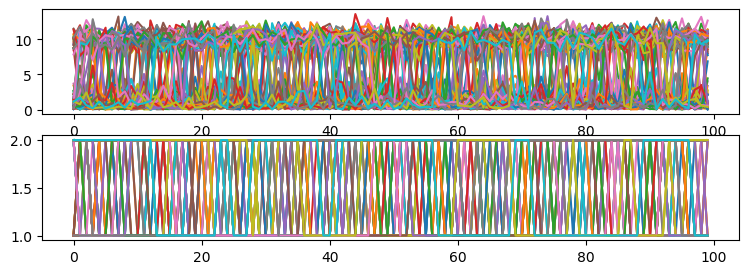

In [36]:
_, axes = subplots(nrows = 2, figsize = (9, 3))
axes[1].plot(y)
axes[2].plot(z, linestyle = "-");

In [37]:
α, logtot = forward(hmm, y)
β, logtot = backward(hmm, y)

γ = posteriors(hmm, y) # or
γ = posteriors(α, β)

size(α), size(β), size(γ)

((100, 2, 100), (100, 2, 100), (100, 2, 100))

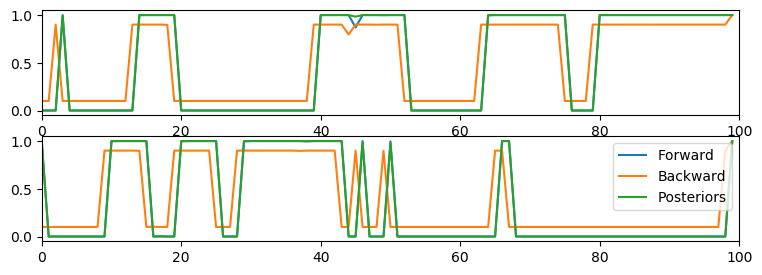

PyObject <matplotlib.legend.Legend object at 0x0000000001D41DD8>

In [38]:
_, axes = subplots(nrows = 2, figsize = (9, 3))
axes[1].plot([α[:, 1, 1] β[:, 1, 1] γ[:, 1, 1]])
axes[1].set_xlim(0, size(y, 1))
axes[2].plot([α[:, 1, 2] β[:, 1, 2] γ[:, 1, 2]])
axes[2].set_xlim(0, size(y, 1))
legend(["Forward", "Backward", "Posteriors"], loc = "upper right")

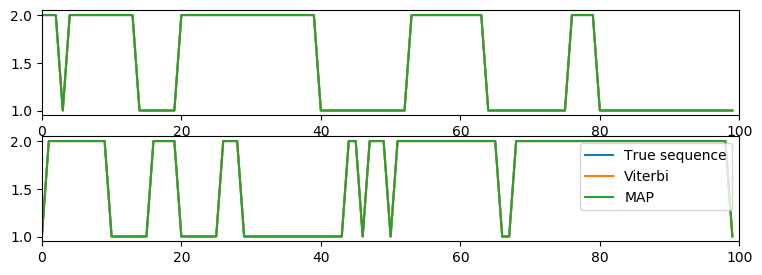

PyObject <matplotlib.legend.Legend object at 0x0000000001E04D30>

In [39]:
z_map = Matrix{Any}(nothing, size(z))
for n in 1:size(γ, 3)
    for t in 1:size(filter(!isnothing, γ[:, 1, n]), 1)
        z_map[t, n] = argmax(γ[t, :, n])
    end
end
z_viterbi, LL = viterbi(hmm, y)

_, axes = subplots(nrows = 2, figsize = (9, 3))
axes[1].plot(z[:, 1], linestyle = "-")
axes[1].plot(z_viterbi[:, 1], linestyle = "-")
axes[1].plot(z_map[:, 1], linestyle = "-")
axes[1].set_xlim(0, size(y, 1))
axes[2].plot(z[:, 2], linestyle = "-")
axes[2].plot(z_viterbi[:, 2], linestyle = "-")
axes[2].plot(z_map[:, 2], linestyle = "-")
axes[2].set_xlim(0, size(y, 1))
legend(["True sequence", "Viterbi", "MAP"], loc = "upper right")

In [41]:
_, K, N = size(γ)
# TODO: change "total_γ" to more suitable name
total_γ = Vector{Float64}(undef, K)
for n in OneTo(N)
    T = length(filter(!isnothing, γ[:, 1, n]))
    for t in OneTo(T)
        for i in OneTo(K)
            total_γ[i] +=  γ[t, i, n]
        end
    end
end

In [56]:
observations = copy(y)
estimator = fit_mle
responsibility = Array{Float64}(undef, 100*100)
for i in OneTo(K)
    γ_ = HMMBase.getnotnothing(γ[:, i, :])
    if sum(filter(!isnothing, γ_)) > 0
        responsibility = vcat(filter(!isnothing, γ[:, i, :]) .* total_γ[i] ./ total_γ[i]...)
#         hmm.B[i] = estimator(typeof(hmm.B[i]), vcat(filter(!isnothing, observations)...), responsibility)
    end
end

Normal{Float64}(μ=10.014515814015281, σ=1.0144438525746156)
Normal{Float64}(μ=1.005525783665104, σ=0.9985542077949103)


In [ ]:
fit_mle(Normal, suffstats(Normal, x, w))

In [53]:
estimator(typeof(hmm.B[1]), vcat(filter(!isnothing, observations)...), responsibility)

Normal{Float64}(μ=10.014515814015281, σ=1.0144438525746156)

In [24]:
hmm, history = fit_mle(hmm, y, display = :final, init = :kmeans)

EM converged in 6 iterations, logtot = -15505.54546890692


(HMM{Univariate,Float64}([0.19812462742814899, 0.801875372571851], [0.8885820733317675 0.11141792666823255; 0.11241791339767972 0.8875820866023203], Distribution{Univariate,S} where S<:ValueSupport[Normal{Float64}(μ=10.014207831234039, σ=1.014782644269319), Gamma{Float64}(α=1.0301632654790387, θ=0.974814568588714)]), Main.HMMBase.EMHistory(true, 6, [-19039.836658741922, -15695.063267588544, -15507.051887427973, -15505.554481584137, -15505.545667656885, -15505.54546890692]))

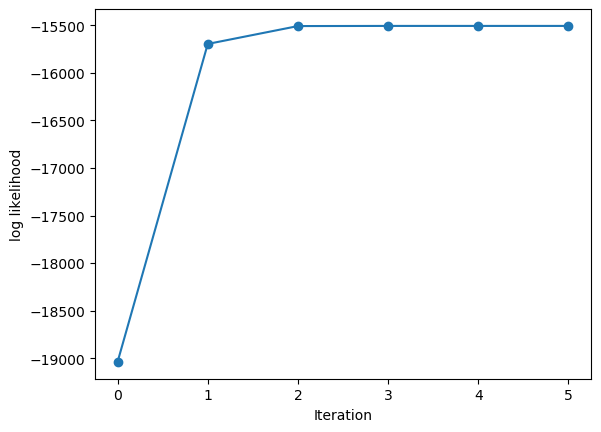

PyObject Text(24.0, 0.5, 'log likelihood')

In [25]:
plot(history.logtots, marker="o")
xlabel("Iteration")
ylabel("log likelihood")

## fixed number of observations with random length

In [10]:
Random.seed!(1234)
z, y = rand(hmm, Poisson(500), 2, seq = true)

(Union{Nothing, Int64}[2 2; 2 2; … ; 2 nothing; 2 nothing], Union{Nothing, Float64}[12.444284720036038 13.12332169030498; 11.46565280185212 15.531152115069274; … ; 10.067873808886167 nothing; 8.796539434931518 nothing])

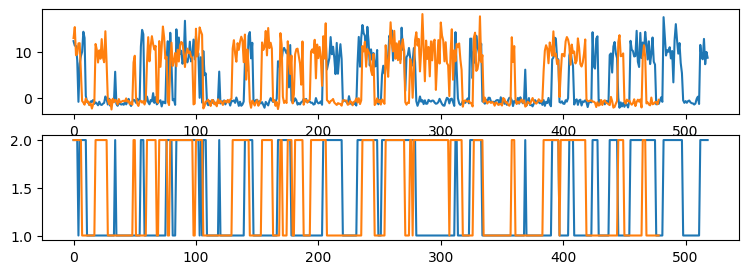

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000062F11CC0>
 PyObject <matplotlib.lines.Line2D object at 0x0000000062F31240>

In [11]:
_, axes = subplots(nrows = 2, figsize = (9, 3))
axes[1].plot(y)
axes[2].plot(z, linestyle = "-")

In [12]:
α, logtot = forward(hmm, y)
β, logtot = backward(hmm, y)

γ = posteriors(hmm, y) # or
γ = posteriors(α, β)

size(α), size(β), size(γ)

((519, 2, 2), (519, 2, 2), (519, 2, 2))

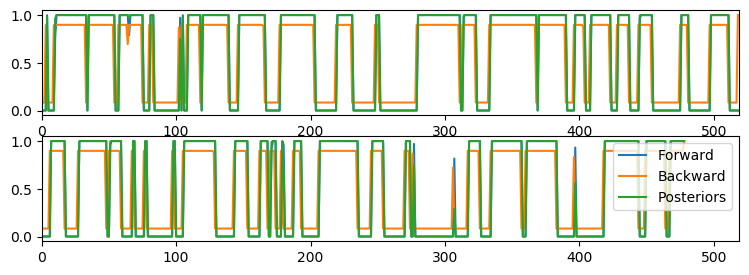

PyObject <matplotlib.legend.Legend object at 0x0000000062FD2E80>

In [13]:
_, axes = subplots(nrows = 2, figsize = (9, 3))
axes[1].plot([α[:, 1, 1] β[:, 1, 1] γ[:, 1, 1]])
axes[1].set_xlim(0, size(y, 1))
axes[2].plot([α[:, 1, 2] β[:, 1, 2] γ[:, 1, 2]])
axes[2].set_xlim(0, size(y, 1))
legend(["Forward", "Backward", "Posteriors"], loc = "upper right")

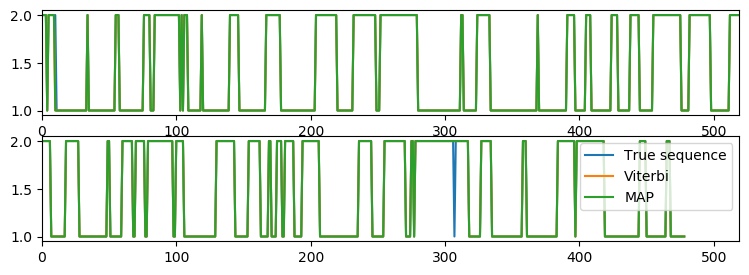

PyObject <matplotlib.legend.Legend object at 0x00000000641676D8>

In [14]:
z_map = Matrix{Any}(nothing, size(z))
for n in 1:size(γ, 3)
    for t in 1:size(filter(!isnothing, γ[:, 1, n]), 1)
        z_map[t, n] = argmax(γ[t, :, n])
    end
end
z_viterbi, LL = viterbi(hmm, y)

_, axes = subplots(nrows = 2, figsize = (9, 3))
axes[1].plot(z[:, 1], linestyle = "-")
axes[1].plot(z_viterbi[:, 1], linestyle = "-")
axes[1].plot(z_map[:, 1], linestyle = "-")
axes[1].set_xlim(0, size(y, 1))
axes[2].plot(z[:, 2], linestyle = "-")
axes[2].plot(z_viterbi[:, 2], linestyle = "-")
axes[2].plot(z_map[:, 2], linestyle = "-")
axes[2].set_xlim(0, size(y, 1))
legend(["True sequence", "Viterbi", "MAP"], loc = "upper right")

In [15]:
hmm, history = fit_mle(hmm, y, display = :final, init = :kmeans)

EM converged in 10 iterations, logtot = -1817.4498344180001


(HMM{Univariate,Float64}([0.0, 1.0], [0.9126271504956085 0.08737284950439159; 0.09922801117977051 0.9007719888202295], Distribution{Univariate,S} where S<:ValueSupport[Normal{Float64}(μ=-0.967088700965017, σ=0.527589288466971), Normal{Float64}(μ=10.05168448016156, σ=2.962389759177027)]), Main.HMMBase.EMHistory(true, 10, [-3166.294607471621, -3105.9573439906944, -2799.456867475995, -2165.940307412997, -1818.564682438312, -1817.4809557676688, -1817.4428588335804, -1817.4470674518798, -1817.4492082971924, -1817.4498344180001]))

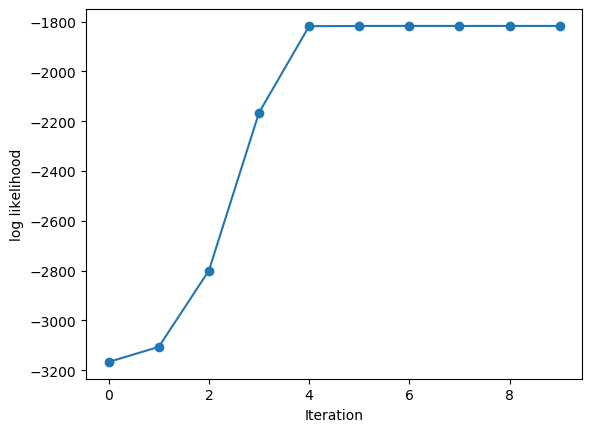

PyObject Text(24.0, 0.5, 'log likelihood')

In [16]:
plot(history.logtots, marker="o")
xlabel("Iteration")
ylabel("log likelihood")

# Multivariate

In [10]:
a = [0.6, 0.4]
A = [0.9 0.1; 0.1 0.9]
B = [MvNormal([0.0, 5.0], ones(2) * 1), MvNormal([0.0, 5.0], ones(2) * 3)]
hmm = HMM(a, A, B)
size(hmm) # (number of states, observations dimension)

(2, 2)

## fixed number of observations with fixed length

In [11]:
Random.seed!(1234)
z, y = rand(hmm, 500, 2, seq = true)
size(z)

(500, 2)

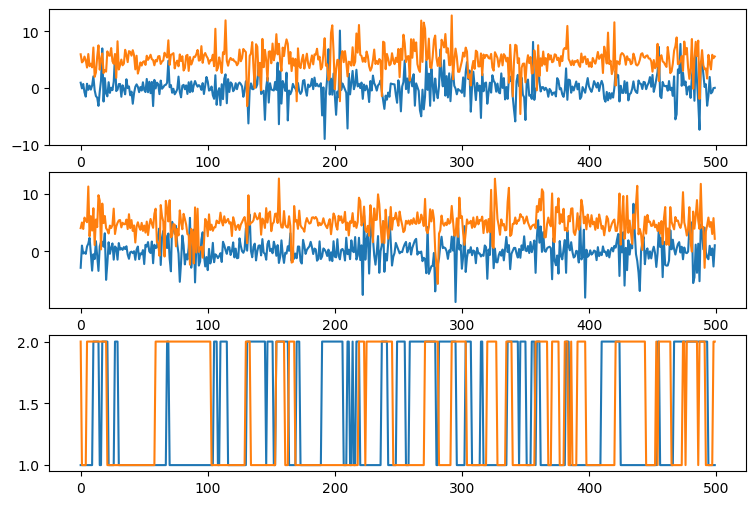

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000000FF7198>
 PyObject <matplotlib.lines.Line2D object at 0x0000000000FF76D8>

In [12]:
_, axes = subplots(nrows = 3, figsize = (9, 6))
axes[1].plot(y[:, :, 1])
axes[2].plot(y[:, :, 2])
axes[3].plot(z, linestyle = "-")

In [13]:
α, logtot = forward(hmm, y)
β, logtot = backward(hmm, y)

γ = posteriors(hmm, y) # or
γ = posteriors(α, β)

size(α), size(β), size(γ)

((500, 2, 2), (500, 2, 2), (500, 2, 2))

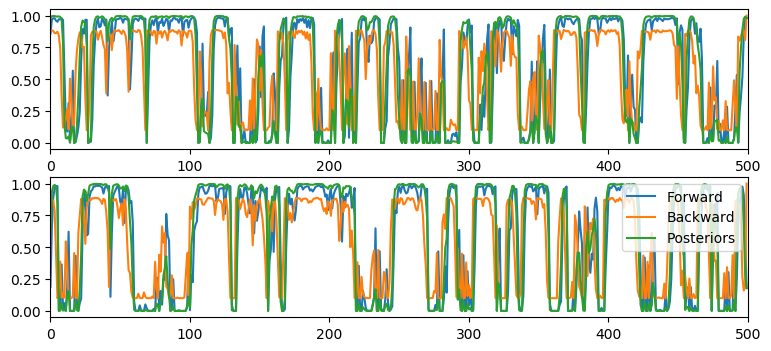

PyObject <matplotlib.legend.Legend object at 0x0000000001102588>

In [14]:
_, axes = subplots(nrows = 2, figsize = (9, 4))
axes[1].plot([α[:, 1, 1] β[:, 1, 1] γ[:, 1, 1]])
axes[1].set_xlim(0, size(y, 1))
axes[2].plot([α[:, 1, 2] β[:, 1, 2] γ[:, 1, 2]])
axes[2].set_xlim(0, size(y, 1))
legend(["Forward", "Backward", "Posteriors"], loc = "upper right")

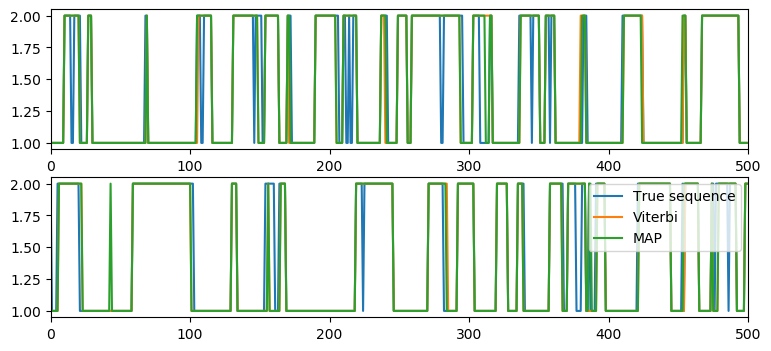

PyObject <matplotlib.legend.Legend object at 0x000000000115CE48>

In [15]:
z_map = Matrix{Any}(nothing, size(z))
for n in 1:size(γ, 3)
    for t in 1:size(filter(!isnothing, γ[:, 1, n]), 1)
        z_map[t, n] = argmax(γ[t, :, n])
    end
end
z_viterbi, LL = viterbi(hmm, y)

_, axes = subplots(nrows = 2, figsize = (9, 4))
axes[1].plot(z[:, 1], linestyle = "-")
axes[1].plot(z_viterbi[:, 1], linestyle = "-")
axes[1].plot(z_map[:, 1], linestyle = "-")
axes[1].set_xlim(0, size(y, 1))
axes[2].plot(z[:, 2], linestyle = "-")
axes[2].plot(z_viterbi[:, 2], linestyle = "-")
axes[2].plot(z_map[:, 2], linestyle = "-")
axes[2].set_xlim(0, size(y, 1))
legend(["True sequence", "Viterbi", "MAP"], loc = "upper right")

In [19]:
hmm, history = fit_mle(hmm, y, display = :final, init = :kmeans)

EM converged in 20 iterations, logtot = -3995.9786631107086


(HMM{Multivariate,Float64}([8.134603059941713e-8, 0.9999999186539694], [0.899371869328016 0.10062813067198392; 0.07786745550917601 0.9221325444908239], Distribution{Multivariate,S} where S<:ValueSupport[DiagNormal(
dim: 2
μ: [0.16064805642926, 4.974212641958539]
Σ: [9.30871128331582 0.0; 0.0 9.765718375034929]
)
, DiagNormal(
dim: 2
μ: [0.038215850438579765, 4.955515084819914]
Σ: [1.083096137953185 0.0; 0.0 0.9936385220271275]
)
]), Main.HMMBase.EMHistory(true, 20, [-4367.8536910467465, -4349.505280964398, -4285.8326763749965, -4169.896273887742, -4072.5503375453777, -4024.420209209987, -4005.1958308243334, -3997.7068630638637, -3995.5489213816886, -3995.3373303497156, -3995.5445923420616, -3995.73605175466, -3995.852982319917, -3995.91586929259, -3995.947980591094, -3995.9640050865123, -3995.9719204217545, -3995.975813302829, -3995.9777248280884, -3995.9786631107086]))

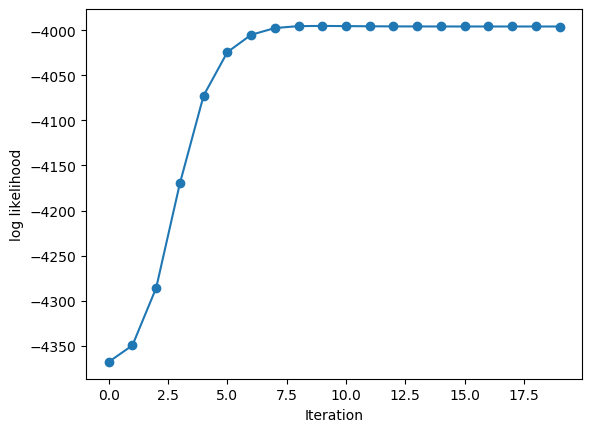

PyObject Text(24.0, 0.5, 'log likelihood')

In [20]:
plot(history.logtots, marker="o")
xlabel("Iteration")
ylabel("log likelihood")

## fixed number of observations with random length

In [37]:
Random.seed!(1234)
z, y = rand(hmm, Poisson(500), 2, seq = true)

(Union{Nothing, Int64}[1 1; 1 1; … ; 1 nothing; 1 nothing], Union{Nothing, Float64}[0.9378142524426818 7.1603412642592215; -0.2445830845722496 5.456248547197689; … ; -0.6794573666575289 5.2609144763809175; -1.0987104159191685 5.0768766116262976]

Union{Nothing, Float64}[2.399752616635875 4.557309526091927; 1.2604749506056312 5.055265268572561; … ; nothing nothing; nothing nothing])

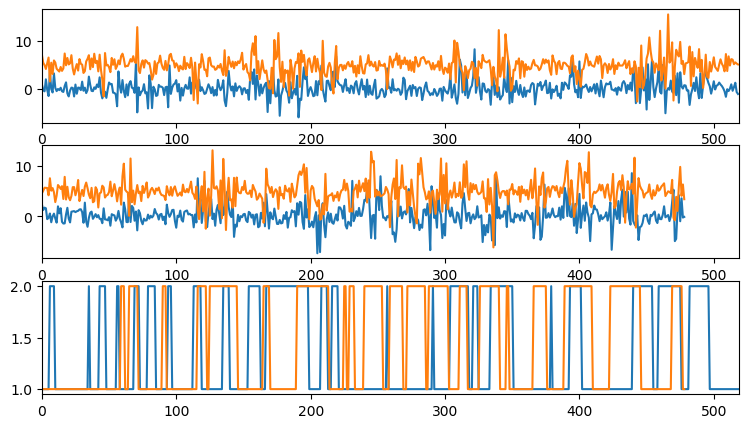

(0, 519)

In [38]:
_, axes = subplots(nrows = 3, figsize = (9, 5))
axes[1].plot(y[:, :, 1])
axes[1].set_xlim(0, size(y[:, :, 1], 1))
axes[2].plot(y[:, :, 2])
axes[2].set_xlim(0, size(y[:, :, 2], 1))
axes[3].plot(z, linestyle = "-")
axes[3].set_xlim(0, size(y[:, :, 1], 1))

In [39]:
# not implemented yet...

α, logtot = forward(hmm, y)
β, logtot = backward(hmm, y)

γ = posteriors(hmm, y) # or
γ = posteriors(α, β)

size(α), size(β), size(γ)

MethodError: MethodError: no method matching -(::Nothing, ::Float64)
Closest candidates are:
  -(!Matched::Float64, ::Float64) at float.jl:403
  -(!Matched::Complex{Bool}, ::Real) at complex.jl:307
  -(!Matched::Missing, ::Number) at missing.jl:115
  ...